# Autoencoders Using CNN

We're using a convolutional neural network in the encoder and decoder architectures here.

## Encoder
The encoder architecture has -
- Conv2d, ReLU, MaxPool2d --> Output = `[16, 14, 14]`
- Conv2d, ReLU, MaxPool2d --> Output = `[32, 6, 6]`
- Conv2d --> Output = `[64, 1, 1]`

## Latent Space Representation
The latent space representation or code has size `[64, 1, 1]` thus representing an image by 64 values.

## Decoder
The decoder architecture has -
- ConvTranspose2d, ReLU --> Output = `[32, 7, 7]`
- ConvTranspose2d, ReLU --> Output = `[16, 14, 14]`
- ConvTranspose2d, ReLU --> Output = `[1, 28, 28]`

In [21]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchsummary import summary
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_workers = os.cpu_count()
batch_size = 32

# Creating transforms for dataloader.
data_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

# Creating the dataloaders
train_data = datasets.MNIST(root='./data', train=True, transform=data_transforms, download=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_data = datasets.MNIST(root='./data', train=False, transform=data_transforms, download=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [15]:
# Creating AutoEncoder
class Autoencoder(nn.Module):
  def __init__(self, embedding_size):
    super().__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1, 1),  # Output --> [16, 28, 28]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [16, 14, 14]
        nn.Conv2d(16, 32, 3, 1),  # Output --> [32, 12, 12]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [32, 6, 6]
        nn.Conv2d(32, 64, 6)  # Output --> [64, 1, 1]
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),  # Output --> [32, 7, 7]
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # Output --> [16, 14, 14]
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1), # Output --> [1, 28, 28]
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [17]:
embedding_size = 7
model = Autoencoder(embedding_size).to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
              ReLU-5           [-1, 32, 12, 12]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 1, 1]          73,792
   ConvTranspose2d-8             [-1, 32, 7, 7]         100,384
              ReLU-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           4,624
             ReLU-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             145
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 183,745
Trainable params:

In [18]:
# Defining loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
# Training
n_epochs = 10
for epoch in range(n_epochs):

  train_loss = 0

  for img, _ in train_dataloader:
    img = img.to(device)
    output_img = model(img)
    loss = loss_fn(output_img, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_dataloader)
  print('Epoch: [{}/{}] | Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: [1/10] | Loss: 0.0251
Epoch: [2/10] | Loss: 0.0072
Epoch: [3/10] | Loss: 0.0054
Epoch: [4/10] | Loss: 0.0046
Epoch: [5/10] | Loss: 0.0041
Epoch: [6/10] | Loss: 0.0037
Epoch: [7/10] | Loss: 0.0035
Epoch: [8/10] | Loss: 0.0034
Epoch: [9/10] | Loss: 0.0033
Epoch: [10/10] | Loss: 0.0033


In [31]:
def show_result(dataloader):
  img, _ = next(iter(dataloader))

  # Plot original images
  plt.figure(figsize=(9, 3))
  for i in range(0, 9):
    plt.subplot(2, 9, i+1)
    plt.imshow(img[i].permute(1, 2, 0), cmap='gray')
    plt.axis(False)
  plt.suptitle(f"Original Images", fontsize=20)

  # Get the output from model and plot reconstructed images
  model.eval()
  with torch.inference_mode():
    plt.figure(figsize=(9, 3))
    output = model(img)
    for i in range(0, 9):
      plt.subplot(2, 9, i+1)
      plt.imshow(output[i].permute(1, 2, 0), cmap='gray')
      plt.axis(False)
    plt.suptitle("Reconstructed Images", fontsize=20)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


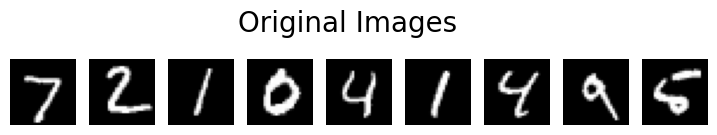

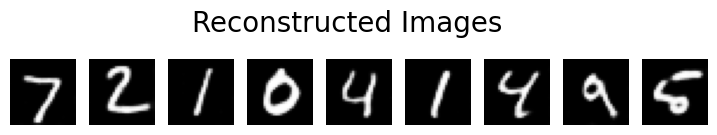

In [32]:
show_result(test_dataloader)